In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
nan_cols = test.isna().sum()
test1 = test.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)
train1 = train.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)

In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# fit and transform the data
test_imputed = pd.DataFrame(imputer.fit_transform(test1), columns=test1.columns)
train_imputed = pd.DataFrame(imputer.fit_transform(train1), columns=train1.columns)

In [5]:
corr_matrix = train_imputed.corr().abs()

corr_y = train_imputed.corrwith(train_imputed['y'])
train_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)
test_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)

# identify predictors that have correlation of >0.85
indices = np.where(np.triu(corr_matrix > 0.85, k=1))

# print the pairs of columns that have a correlation > 0.7
high_corr = []
count = 0
for idx in range(len(indices[0])):
    col1 = corr_matrix.columns[indices[0][idx]]
    col2 = corr_matrix.columns[indices[1][idx]]
    high_corr.append(col1)
    count+=1
    #print(f"{col1} and {col2}")
#print(count)

unique_vals = set(high_corr)
train_imputed = train_imputed.drop(unique_vals, axis = 1)

test_col = train_imputed.drop('y', axis = 1)
test_imputed = test_imputed[test_col.columns]

### Scaling data

In [8]:
X = train_imputed.drop('y', axis = 1)
y = train_imputed.y

In [9]:
X_test = test_imputed

In [10]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

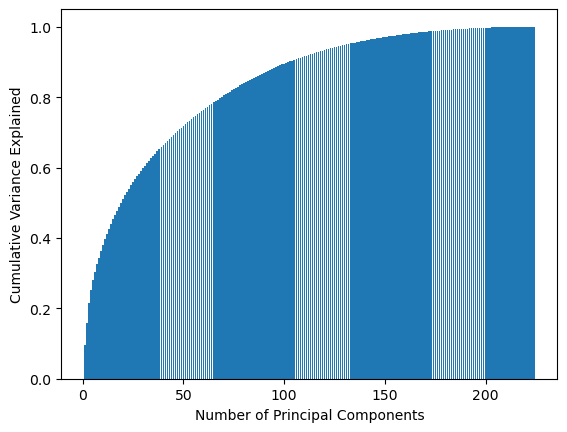

In [11]:
from sklearn.decomposition import PCA
plt.rcParams.update(plt.rcParamsDefault)
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratios
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative sum of the explained variance ratios against the number of principal components
plt.bar(range(1, pca.n_components_ + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [12]:
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)

PCA(n_components=0.95)